<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-BlackPuma075/blob/main/Dic_08_14/EDR_NN_Binary_QSO_STAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Proyecto Final - Machine Learning**

Diciembre 2023

*Diego González Sandoval (UG)*

**Objetivos**


*   Filtrar los datos de Quásares (QSO) y Estrellas (STAR).
*   Descargar la información relacionada a la longitud de onda y el flujo de estos objetos.
*   Crear una red neuronal que sea capaz de identificar uno de estos dos objetos en base a su espectro.
*   Comparar con el data set de identificación visual (Human efficiency).



**Procedicimiento**

*   Acceder a los datos filtrados donde solo existan TargetIDs de QSO y STARS.
*   Descargar la información de 100 objetos de estos tipos.
*   Graficar espectros de algunos de estos objetos para comparar visualmente los espectos.
*   Crear una red neuronal para probar la arquitectura con 100 objetos y corroborar que el código no tiene errores.
*   Probar la red para un data set más grande.
*   Comparar con la eficiencia humana.

**Introducción**

Los cuásares son núcleos galácticos extremadamente luminosos, pero muy distantes a la Tierra, los cuásares más cercanos están a ~600 millones de años luz. Estos objetos emiten radiación electromagnética en todo el espectro. En cambio las estrellas son objetos súmamente comunes en el universo. Su composición y estructura nos ayuda a determinar la historia de las galaxias, por lo que su estudio es de gran importancia para la ciencia.

In [1]:
!pip install fitsio
!wget https://github.com/desihub/tutorials/blob/main/mpl/desi.mplstyle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fitsio: filename=fitsio-1.2.1-cp310-cp310-linux_x86_64.whl size=817575 sha256=114895a63f6b61329f0ca036a83dd20e4a6989ac4619087a1c221c424c076e7e
  Stored in directory: /root/.cache/pip/wheels/94/70/18/2789914e7e79d73c282daba3cc5e5984c5e9a84962f68bf7bc
Successfully built fitsio
--2023-12-13 02:47:17--  https://github.com/desihub/tutorials/blob/main/mpl/desi.mplstyle
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5530 (5.4K) [text/plain]
Saving to: ‘desi.mplstyle’

desi.mplstyle       100%[===================>]   5.40K  --.-KB/s    in 0s      

2023-12-13 02:47:17 (73.5 MB/s) - ‘desi.mplstyle’ saved [5530/5530]



In [2]:
from   google.colab import drive
import os
import sys
import subprocess

In [3]:
drivepath='/content/drive/'
drive.mount(drivepath, force_remount=True)
desiedr_path = drivepath + '/MyDrive/desi_edr/'
desicode_path = desiedr_path+'/desicode'
specprod = 'fuji'    # Internal name for the EDR
specprod_dir = desiedr_path+specprod

Mounted at /content/drive/


In [4]:
specprod_dir

'/content/drive//MyDrive/desi_edr/fuji'

In [5]:
#Check that directory structure exist, otherwise create the necesary directories.
if not os.path.exists(desiedr_path):
  os.makedirs(desiedr_path)
if not os.path.exists(specprod_dir):
  os.makedirs(specprod_dir)
if not os.path.exists(specprod_dir+'/zcatalog'):
  os.makedirs(specprod_dir+'/zcatalog')
if not os.path.exists(specprod_dir+'/healpix'):
  os.makedirs(specprod_dir+'/healpix')
if not os.path.exists(desicode_path):
  os.makedirs(desicode_path)

#clone desicode.
#You have to do this only once, you could comment these cells afterwards.
#os.chdir(desicode_path)
#subprocess.run('git clone https://github.com/desihub/desitarget.git --depth=1', shell=True, check=True)
#subprocess.run('git clone https://github.com/desihub/desiutil.git --depth=1', shell=True, check=True)
#subprocess.run('git clone https://github.com/desihub/desispec.git --depth=1', shell=True, check=True)
#subprocess.run('git clone https://github.com/desihub/desimodel.git --depth=1', shell=True, check=True)
#subprocess.run('git clone https://github.com/desihub/speclite.git --depth=1', shell=True, check=True)


In [6]:
#This lines adds the code paths to the main path to look for the relevan libraries,
#so we don't have to actually install the code.
sys.path.insert(1,desicode_path+"/desitarget/py/")
sys.path.insert(1,desicode_path+"/desiutil/py/")
sys.path.insert(1,desicode_path+"/desispec/py/")
sys.path.insert(1,desicode_path+"/desimodel/py/")
sys.path.insert(1,desicode_path+'/speclite/')

In [7]:
import numpy as np

import fitsio

from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

#-- input/output functions related to DESI spectra
import desispec.io
#plt.style.use("desi.mplstyle")


/content/drive//MyDrive/desi_edr//desicode/desispec/py/desispec/qproc/qextract.py:19: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_extract(image_flux,image_var,x,hw=3) :
/content/drive//MyDrive/desi_edr//desicode/desispec/py/desispec/image_model.py:27: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_proj(image,x,sigma,flux) :
/content/drive//M

In [8]:
import urllib.request
# Release directory path

catalog_url= "https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/zcatalog/"
base_url= "https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/"

zcat_pix= "zall-pix-fuji.fits"
local_zcat_pix = os.path.join(desiedr_path+'/fuji/zcatalog/',zcat_pix)

if not os.path.exists(local_zcat_pix):
        #os.makedirs(desiedr_path+'/fuji/zcatalog/')
        print("downloading DESI catalog from %s to %s"
              % (catalog_url+zcat_pix, local_zcat_pix ))
        tmp = urllib.request.urlretrieve(catalog_url+zcat_pix,local_zcat_pix)
        print ("Downloaded file"+local_zcat_pix)
else:
    print("%s already exist"%(local_zcat_pix))

/content/drive//MyDrive/desi_edr//fuji/zcatalog/zall-pix-fuji.fits already exist


In [65]:
fujidata = Table( fitsio.read(local_zcat_pix))

In [ ]:
from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask
# from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask  # SV1
# from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask  # SV2
# from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask  # SV3


In [ ]:
#-- select the target mask for each type of target (BGS, LRG, ELG, QSO, etc.)

bgs_tgtmask  = desi_mask["BGS_ANY"]
lrg_tgtmask  = desi_mask["LRG"]
elg_tgtmask  = desi_mask["ELG"]
qso_tgtmask  = desi_mask["QSO"]
mws_tgtmask  = desi_mask["MWS_ANY"]
scnd_tgtmask = desi_mask["SCND_ANY"]


In [66]:
#Imprimo la información de los datos

fujidata

TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,str7,str6,int32,int32,float64,float64,int64,float64,float64[10],int64,str6,str20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,str3,float64,int32,int16,str8,int32,int32,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,str1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int64,bool
616089230757593610,cmx,other,2152,2152,1.0791710884059862,8.043609933906356e-05,5,8196.955931693316,-31.270945382111947 .. -4.304250468199833,7928,GALAXY,,10,8.043657064437866,0,23.914121939862518,29.974787585945496,0.0,0.0,0.0,4294967296,4,SKY,0.8476382465505894,63,9010,0240p300,495765,522,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-0.003990191,0.026369713,0.0027650434,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,,-1,-1,4294967296,4294967296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.914121939862518,29.974787585945496,4,3600.0,1,1,-0.004,0.008336666,-0.00275,0.009987492,23.914140396147115,0.14040637,29.974777243955057,0.12941206,0.793052,639.917,0.3878204,121.14421,339.00644,2058.3599,832.6921,10.254479,3.4988468,43286.7,93.85132,7782.0195,0.16086136,8970.089,47104.805,28.528677,136.52605,5.594912e-05,293.99265,1.0618171e-05,0.0,13069.495,7.403538e-05,60.08052,135.6212,43926.617,388.23178,7903.1636,339.1673,24097.945,47937.496,98.86368,275.6461,0,False,1,True
39628473202904408,cmx,other,2152,2152,0.18041222201570103,8.931818686229672e-06,0,12949.879635035992,-109.46447587943996 .. 12.118995244141198,7926,GALAXY,,10,8801.990980923176,0,24.04010479193436,29.813362596941825,0.0,0.0,2020.9597,72057594037929216,1,TGT,0.6306843567905966,7,9010,,494513,3416,DEV,0.047077972,6.2664,17.88001,40.539513,59.783627,50.919693,533.2463,113.88678,26.52623,-1.0,-1.0,2.5057633,7.149731,16.210651,2.5057633,7.149731,16.210651,0,4.0,0.96060556,-0.2916907,-0.14283308,0,,0.0,0.0,0.0,0.0,S,3200,1,72057594037929216,0,0,0,0,0

In [67]:
#De la lista anterior solo necesitaremos la información del TargetID el corrimiento al rojo, y el spectype

fujidata = fujidata['TARGETID','SURVEY','SPECTYPE','Z']

In [68]:
fujidata

TARGETID,SURVEY,SPECTYPE,Z
int64,str7,str6,float64
616089230757593610,cmx,GALAXY,1.0791710884059862
39628473202904408,cmx,GALAXY,0.18041222201570103
39628473202902554,cmx,GALAXY,0.4461359257327492
616089225506325615,cmx,GALAXY,0.6192322343815375
39628473202903445,cmx,QSO,1.0724836869842256
39628473202903539,cmx,STAR,-0.0019956912923479522
1152921504619435527,cmx,STAR,-3.7560540650860466e-05
39628473202904338,cmx,GALAXY,0.8033783177649549
39628473202902855,cmx,GALAXY,0.42633336573476377


In [69]:
#Creo dos mask para filtrar y crear un set de datos nuevo donde sólo estén los TagetID de estos objetos

qso_mask  = fujidata["SPECTYPE"]=='QSO'
star_mask = fujidata["SPECTYPE"]=='STAR'

In [70]:
#Ahora tengo dos máscaras para filtrar los datos dónde solo hay información acerca de estos objetos

fujidata[qso_mask]

TARGETID,SURVEY,SPECTYPE,Z
int64,str7,str6,float64
39628473202903445,cmx,QSO,1.0724836869842256
39628473202905021,cmx,QSO,2.628380234087188
39628478449979760,cmx,QSO,1.5284469839389512
39628478454170137,cmx,QSO,2.437912157749145
1152921504619432614,cmx,QSO,1.1294203675694041
39628488931543273,cmx,QSO,0.5879885699941647
39628483705443044,cmx,QSO,3.641069952113342
39628488927348831,cmx,QSO,1.403102792557713
39628483705441129,cmx,QSO,1.9052059263390442


In [71]:
#Creo dos conjuntos de datos, cada uno con sólo información sobre Cuásares y el otro Estrellas

data1 = fujidata[qso_mask]
data2 = fujidata[star_mask]

In [72]:
data1

TARGETID,SURVEY,SPECTYPE,Z
int64,str7,str6,float64
39628473202903445,cmx,QSO,1.0724836869842256
39628473202905021,cmx,QSO,2.628380234087188
39628478449979760,cmx,QSO,1.5284469839389512
39628478454170137,cmx,QSO,2.437912157749145
1152921504619432614,cmx,QSO,1.1294203675694041
39628488931543273,cmx,QSO,0.5879885699941647
39628483705443044,cmx,QSO,3.641069952113342
39628488927348831,cmx,QSO,1.403102792557713
39628483705441129,cmx,QSO,1.9052059263390442


In [73]:
data2

TARGETID,SURVEY,SPECTYPE,Z
int64,str7,str6,float64
39628473202903539,cmx,STAR,-0.0019956912923479522
1152921504619435527,cmx,STAR,-3.7560540650860466e-05
39628473198711006,cmx,STAR,-6.607473910190775e-05
1152921504619435582,cmx,STAR,9.833583812940401e-05
39628473198711342,cmx,STAR,-0.0019956912923479522
39628494145064337,cmx,STAR,-0.0019956912923479522
1152921504619435605,cmx,STAR,-0.00018759545042438264
39628483705440899,cmx,STAR,-0.000245578117524253
39628488931545498,cmx,STAR,-0.0019956912923479522


In [55]:
#Por los datos de table lenght observamos que hay 44794 datos de quásares en el sv1
#y 327953 datos de estrellas, pero comenzaremos con seleccionar 100 para las pruebas iniciales
#50 de cuásares y 50 de estrellas

In [74]:
#Comenzaré por hacer dos subconjuntos para probar el código, con 50 TragetIDs de cada tipo de objeto

subdata1 = data1[0:50:1]
subdata1

TARGETID,SURVEY,SPECTYPE,Z
int64,str7,str6,float64
39628473202903445,cmx,QSO,1.0724836869842256
39628473202905021,cmx,QSO,2.628380234087188
39628478449979760,cmx,QSO,1.5284469839389512
39628478454170137,cmx,QSO,2.437912157749145
1152921504619432614,cmx,QSO,1.1294203675694041
39628488931543273,cmx,QSO,0.5879885699941647
39628483705443044,cmx,QSO,3.641069952113342
39628488927348831,cmx,QSO,1.403102792557713
39628483705441129,cmx,QSO,1.9052059263390442


In [84]:
subdata2 = data2[1:51:1]
subdata2

TARGETID,SURVEY,SPECTYPE,Z
int64,str7,str6,float64
1152921504619435527,cmx,STAR,-3.7560540650860466e-05
39628473198711006,cmx,STAR,-6.607473910190775e-05
1152921504619435582,cmx,STAR,9.833583812940401e-05
39628473198711342,cmx,STAR,-0.0019956912923479522
39628494145064337,cmx,STAR,-0.0019956912923479522
1152921504619435605,cmx,STAR,-0.00018759545042438264
39628483705440899,cmx,STAR,-0.000245578117524253
39628488931545498,cmx,STAR,-0.0019956912923479522
39628483705439436,cmx,STAR,-0.0019956912923479522


In [85]:
#Creo un sólo set de datos con los 100 datos juntos

subdata = vstack((subdata1, subdata2))
subdata

TARGETID,SURVEY,SPECTYPE,Z
int64,str7,str6,float64
39628473202903445,cmx,QSO,1.0724836869842256
39628473202905021,cmx,QSO,2.628380234087188
39628478449979760,cmx,QSO,1.5284469839389512
39628478454170137,cmx,QSO,2.437912157749145
1152921504619432614,cmx,QSO,1.1294203675694041
39628488931543273,cmx,QSO,0.5879885699941647
39628483705443044,cmx,QSO,3.641069952113342
39628488927348831,cmx,QSO,1.403102792557713
39628483705441129,cmx,QSO,1.9052059263390442


In [34]:
#Lo siguiente que haré es descargar los datos de cada uno de estos objetos de la siguiente manera

!pip install sparclclient

In [35]:
from sparcl.client import SparclClient

In [90]:
#Probaré el siguiente código para una estrella

client = SparclClient()

spectra = client.retrieve_by_specid([int(subdata["TARGETID"][50]),],
    include=['wavelength', 'flux'])
spec = spectra.records[0]

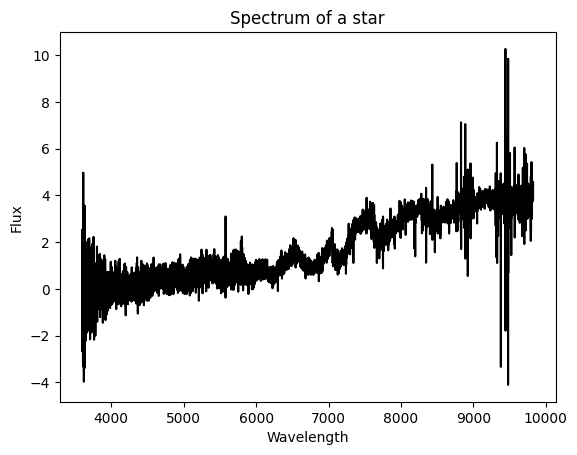

In [91]:
#Grafico este espectro
plt.plot(spec.wavelength, spec.flux, 'black')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Spectrum of a star')
plt.show()

In [139]:
#Veamos ahora el de un quasar

client = SparclClient()

spectra = client.retrieve_by_specid([int(subdata["TARGETID"][0]),],
    include=['wavelength', 'flux'])
spec = spectra.records[0]

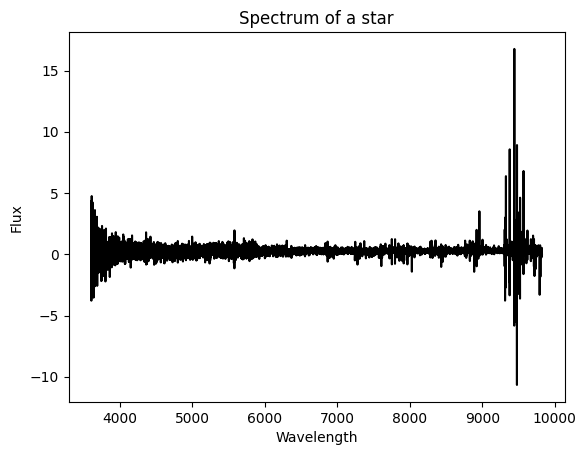

In [140]:
plt.plot(spec.wavelength, spec.flux, 'black')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Spectrum of a star')
plt.show()

In [154]:
#En este cuadro de código asigno solo la información del flujo del espectro 0 de la lista de 100 espectros
#Para poder hacer el vstack y descargar la información (flujo) de los otros 99

specs3 = spec['flux']
specs3.shape

(7781,)

In [153]:
#En este cuadro creo un array donde guardaré los TARGETID de los espectros

y = np.zeros(100)
y[0] = int(subdata['TARGETID'][0])

In [155]:
#Ahora hago este mismo procedimiento pero para todos los 100 objetos

client = SparclClient()
for i in range(len(subdata)-1):
  try:
    spectra = client.retrieve_by_specid([int(subdata["TARGETID"][i+1]),], #Comienzo en 1 debido a que el tid 0 lo usé para la var. specs1
        include=['wavelength', 'flux'])
    y[i+1] = int(subdata['TARGETID'][i+1])
    spec = spectra.records[0]
    specs3 = np.vstack((specs3,spec['flux'].T))
  except IndexError:
    y[i] = 0
    pass

In [156]:
specs3.shape, y.shape #Ahora tengo el espectro de 88 objetos (12 objetos arrojaron error) y sus targetid en la variable y

((88, 7781), (100,))

In [160]:
#Eliminamos los ceros en la variable y, la cual guardó los tids de cada espectro

for i in range(len(y)):
  if y[i]==0:
    y = np.delete(y,i)

IndexError: ignored

In [161]:
y.shape #Al eliminar los ceros este arreglo obtenemos el arreglo sin los targetids que tenían algún error

(88,)

In [162]:
y

array([3.96284732e+16, 3.96284732e+16, 3.96284784e+16, 3.96284785e+16,
       1.15292150e+18, 3.96284889e+16, 3.96284837e+16, 3.96284889e+16,
       3.96284837e+16, 3.96284837e+16, 6.16089241e+17, 3.96284889e+16,
       3.96284889e+16, 3.96284837e+16, 1.15292150e+18, 3.96284889e+16,
       3.96284941e+16, 3.96284837e+16, 3.96284785e+16, 3.96284785e+16,
       3.96284785e+16, 3.96284785e+16, 3.96284785e+16, 3.96284732e+16,
       3.96284785e+16, 3.96284785e+16, 3.96284889e+16, 3.96284785e+16,
       1.15292150e+18, 3.96284837e+16, 3.96284785e+16, 3.96284732e+16,
       3.96284837e+16, 3.96284785e+16, 3.96284837e+16, 3.96284837e+16,
       1.15292150e+18, 1.15292150e+18, 3.96284784e+16, 3.96284784e+16,
       3.96284784e+16, 3.96284837e+16, 3.96284784e+16, 1.15292150e+18,
       1.15292150e+18, 3.96284993e+16, 3.96284993e+16, 6.16089246e+17,
       1.15292150e+18, 3.96284732e+16, 1.15292150e+18, 3.96284732e+16,
       3.96284941e+16, 1.15292150e+18, 3.96284837e+16, 3.96284889e+16,
      

Text(0.5, 1.0, 'Spectrum 10 of the train set')

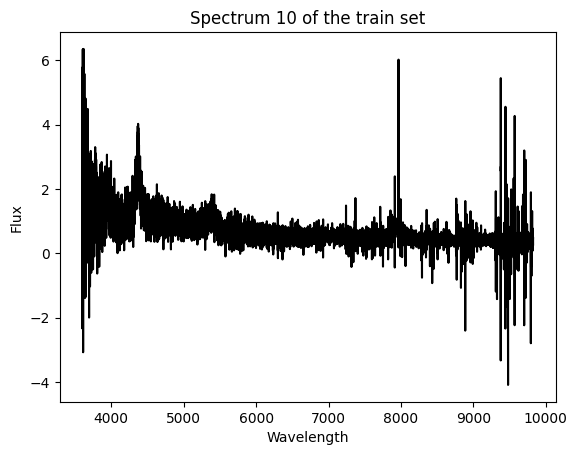

In [163]:
plt.plot(spec.wavelength,specs3[10], 'black') #Grafico uno de los espectros guardados en la lista specs13 para corroborar
#que se guardaron correctamente, en este caso imprimí el 10 solo por aleatoreidad
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Spectrum 10 of the train set')

In [164]:
#Ahora tengo datos de 88 objetos, y sus 88 tids
specs3.shape, y.shape

((88, 7781), (88,))

In [165]:
subdata['SPECTYPE'][60]

'STAR'

In [166]:
for i in range(len(y)):
  if subdata['SPECTYPE'][i+1] == 'QSO':
    y[i] = int(0)
  if subdata['SPECTYPE'][i+1] == 'STAR':
    y[i] = int(1)

y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [167]:
#Ahora y es nuestro conjunto de prueba, con 0 si el elmento es un cuásar, y 1 si es una estrella

In [168]:
import glob
import copy
import h5py
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
%matplotlib inline

In [169]:
#Nuestros datos ya están de la forma (n features, n samples), solo hay que normalizarlos
#Renombro los datos solo para tener una notación más familiar y fácil de recordar
X_flatten = specs3.T
Y = y

scaler=preprocessing.StandardScaler().fit(X_flatten)
X_scaled = scaler.transform(X_flatten)
X_scaled.shape

(7781, 88)

In [170]:
#Preparamos los conjuntos de entrenamiento y de prueba

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_scaled.T,Y, test_size=0.10, random_state=42,shuffle= True) #Hago shuffle = True para que no estén los datos sesgados (50,50) en ese orden

In [171]:
x_train.shape,x_test.shape #Las dimensiones son correctas: (nsamples,nfeatures)

((79, 7781), (9, 7781))

In [172]:
#Importamos librerías de tf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [173]:
tf.random.set_seed(1234) #Pruebo un modelo, el más simple para verificar que los datos están bien preparados, una sola neurona con función de acitvación sigmoide y densa, es decir que usamos todos los datos de entrada en la neurona.
model = Sequential(
    [
        tf.keras.Input(shape=(x_train.shape[1],)),
        Dense(1, activation='sigmoid', name = 'layer1'),
     ]
)

In [174]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 1)                 7782      
                                                                 
Total params: 7782 (30.40 KB)
Trainable params: 7782 (30.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [175]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer='sgd',
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [176]:
model.fit(
    x_train,y_train,
    batch_size=8, #Uso un batch de 8 y 8 épocas para que coincida con el tamaño del set (88 datos)
    epochs=11,
)

y_pred_test = model.predict(x_test)
y_pred_test = (y_pred_test >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

Epoch 1/11
10/10 [==============================] - 1s 4ms/step - loss: 1.0121 - binary_accuracy: 0.6709
Epoch 2/11
10/10 [==============================] - 0s 4ms/step - loss: 0.3095 - binary_accuracy: 0.9494
Epoch 3/11
10/10 [==============================] - 0s 3ms/step - loss: 0.3161 - binary_accuracy: 0.9620
Epoch 4/11
10/10 [==============================] - 0s 4ms/step - loss: 0.1947 - binary_accuracy: 1.0000
Epoch 5/11
10/10 [==============================] - 0s 4ms/step - loss: 0.4284 - binary_accuracy: 0.9241
Epoch 6/11
10/10 [==============================] - 0s 3ms/step - loss: 0.2361 - binary_accuracy: 0.9747
Epoch 7/11
10/10 [==============================] - 0s 3ms/step - loss: 0.2302 - binary_accuracy: 0.9494
Epoch 8/11
10/10 [==============================] - 0s 4ms/step - loss: 0.1728 - binary_accuracy: 1.0000
Epoch 9/11
10/10 [==============================] - 0s 3ms/step - loss: 0.1815 - binary_accuracy: 0.9873
Epoch 10/11
10/10 [==============================] - 0s

Para esta primera prueba que solo era para corroborar todo el procesamiento de los datos, observamos que el test da un accuracy de 53%, pero es un data set muy pequeño, lo siguiente que haré será probar un par de arquitecturas más para analizar su accuracy y probarlos más adelante en un data set mucho más grande. Tampoco haré validation split debido al tamaño tan reducido de los datos.

In [177]:
tf.random.set_seed(1234)  #Pruebo un segundo modelo, denso también, con 3 capas y 16 neuronas para comparar el rendimiento.
model2 = Sequential(
    [
        tf.keras.Input(shape=(x_train.shape[1],)),
        Dense(10, activation='relu', name = 'layer0'), #La capa 0 es de 10 neuronas con func. de act. relu
        Dense(5, activation='relu', name = 'layer1'), #La capa 1 es de 5 neuronas con func. de act. relu
        Dense(1, activation='sigmoid', name = 'layer2'), #La capa de salida es una neurona con func. de act. sigmoide, debido a que es una clasificación binaria
     ]
)
model2.summary()
model2.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer='sgd',
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (Dense)              (None, 10)                77820     
                                                                 
 layer1 (Dense)              (None, 5)                 55        
                                                                 
 layer2 (Dense)              (None, 1)                 6         
                                                                 
Total params: 77881 (304.22 KB)
Trainable params: 77881 (304.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [178]:
model2.fit(
    x_train,y_train,
    epochs=11,
    batch_size=8,
)


y_pred_test1 = model2.predict(x_test)
y_pred_test1 = (y_pred_test1 >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test1 - y_test)) * 100))

Epoch 1/11
10/10 [==============================] - 1s 4ms/step - loss: 0.6461 - binary_accuracy: 0.5190
Epoch 2/11
10/10 [==============================] - 0s 3ms/step - loss: 0.4033 - binary_accuracy: 0.7215
Epoch 3/11
10/10 [==============================] - 0s 2ms/step - loss: 0.3212 - binary_accuracy: 0.9747
Epoch 4/11
10/10 [==============================] - 0s 3ms/step - loss: 0.2913 - binary_accuracy: 0.9494
Epoch 5/11
10/10 [==============================] - 0s 2ms/step - loss: 0.2733 - binary_accuracy: 0.9747
Epoch 6/11
10/10 [==============================] - 0s 2ms/step - loss: 0.2603 - binary_accuracy: 0.9747
Epoch 7/11
10/10 [==============================] - 0s 2ms/step - loss: 0.2464 - binary_accuracy: 0.9620
Epoch 8/11
10/10 [==============================] - 0s 3ms/step - loss: 0.2217 - binary_accuracy: 0.9747
Epoch 9/11
10/10 [==============================] - 0s 3ms/step - loss: 0.2106 - binary_accuracy: 0.9747
Epoch 10/11
10/10 [==============================] - 0s

Notamos que neuvamente la precición binaria es muy alta, pero esto puede deberse al tamaño del data set y que la red es un poco más compleja que la anterior, además hubo un aumento del 6% en el test accuracy.

In [179]:
tf.random.set_seed(1234)  #El tercer modelo consiste de 4 capas, con 61 neuronas, de la capa 1-3 con func. de act. relu y de salida sigmoide nuevamente
model3 = Sequential(
    [
        tf.keras.Input(shape=(x_train.shape[1],)),
        Dense(30, activation='relu', name = 'layer0'),
        Dense(20, activation='relu', name = 'layer1'),
        Dense(10, activation='relu', name = 'layer2'),
        Dense(1, activation='sigmoid', name = 'layer3'),
     ]
)
model3.summary()
model3.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer='sgd',
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (Dense)              (None, 30)                233460    
                                                                 
 layer1 (Dense)              (None, 20)                620       
                                                                 
 layer2 (Dense)              (None, 10)                210       
                                                                 
 layer3 (Dense)              (None, 1)                 11        
                                                                 
Total params: 234301 (915.24 KB)
Trainable params: 234301 (915.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [180]:
model3.fit(
    x_train,y_train,
    epochs=10,
    batch_size=20,
    validation_split=0.1
)

y_hat = model3.predict(x_test)
y_hat= (y_hat >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_hat - y_test)) * 100))

Epoch 1/10
4/4 [==============================] - 1s 77ms/step - loss: 0.6915 - binary_accuracy: 0.5775 - val_loss: 0.6034 - val_binary_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 0s 19ms/step - loss: 0.5952 - binary_accuracy: 0.6197 - val_loss: 0.5417 - val_binary_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 0s 13ms/step - loss: 0.5290 - binary_accuracy: 0.6761 - val_loss: 0.5098 - val_binary_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: 0.4860 - binary_accuracy: 0.6901 - val_loss: 0.4979 - val_binary_accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 0s 14ms/step - loss: 0.4538 - binary_accuracy: 0.6901 - val_loss: 0.4836 - val_binary_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 0s 14ms/step - loss: 0.4240 - binary_accuracy: 0.7042 - val_loss: 0.4765 - val_binary_accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 0s 15ms/step - loss: 0.4036 - bi

En este caso se sobre ajusta la validación binaria debido a que el 10% de estos datos es muy pequeño, pero el test accuracy es del 65.43%, 6% mejor que el anterior.

In [181]:
tf.random.set_seed(1234)
model4 = Sequential(
    [
        tf.keras.Input(shape=(x_train.shape[1],)),
        Dense(40, activation='relu', kernel_initializer='he_uniform', name = 'layer0'),
        Dropout(0.1),
        Dense(30, activation='relu',kernel_initializer='he_uniform', name = 'layer1'),
        Dropout(0.1),
        Dense(20, activation='relu',kernel_initializer='he_uniform', name = 'layer2'),
        Dropout(0.1),
        Dense(1, activation='sigmoid',kernel_initializer='he_uniform', name = 'layer3'),
     ]
)
model4.summary()
model4.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer='sgd',
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (Dense)              (None, 40)                311280    
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 layer1 (Dense)              (None, 30)                1230      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 layer2 (Dense)              (None, 20)                620       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 layer3 (Dense)              (None, 1)                

In [182]:
model4.fit(
    x_train,y_train,
    epochs=11,
    batch_size=8,
    validation_split=0.1
)

y_hat = model4.predict(x_test)
y_hat= (y_hat >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_hat - y_test)) * 100))

Epoch 1/11
9/9 [==============================] - 1s 42ms/step - loss: 0.6561 - binary_accuracy: 0.4930 - val_loss: 0.4361 - val_binary_accuracy: 0.5000
Epoch 2/11
9/9 [==============================] - 0s 7ms/step - loss: 0.5789 - binary_accuracy: 0.6056 - val_loss: 0.5389 - val_binary_accuracy: 0.3750
Epoch 3/11
9/9 [==============================] - 0s 6ms/step - loss: 0.4221 - binary_accuracy: 0.8732 - val_loss: 0.4730 - val_binary_accuracy: 1.0000
Epoch 4/11
9/9 [==============================] - 0s 8ms/step - loss: 0.3946 - binary_accuracy: 0.9014 - val_loss: 0.4824 - val_binary_accuracy: 1.0000
Epoch 5/11
9/9 [==============================] - 0s 6ms/step - loss: 0.3424 - binary_accuracy: 0.9014 - val_loss: 0.4659 - val_binary_accuracy: 1.0000
Epoch 6/11
9/9 [==============================] - 0s 6ms/step - loss: 0.3132 - binary_accuracy: 0.9718 - val_loss: 0.5780 - val_binary_accuracy: 0.8750
Epoch 7/11
9/9 [==============================] - 0s 7ms/step - loss: 0.3333 - binary_a

In [183]:
tf.random.set_seed(1234)
model5 = Sequential(
    [
        tf.keras.Input(shape=(x_train.shape[1],)),
        Dense(100, activation='relu', kernel_initializer='he_uniform', name = 'layer0'),
        Dropout(0.1),
        Dense(100, activation='relu',kernel_initializer='he_uniform', name = 'layer1'),
        Dropout(0.1),
        Dense(100, activation='relu',kernel_initializer='he_uniform', name = 'layer2'),
        Dropout(0.1),
        Dense(1, activation='sigmoid',kernel_initializer='he_uniform', name = 'layer3'),
     ]
)
model5.summary()
model5.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer='sgd',
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (Dense)              (None, 100)               778200    
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 layer1 (Dense)              (None, 100)               10100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 layer2 (Dense)              (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 layer3 (Dense)              (None, 1)                

In [184]:
history5 = model5.fit(
    x_train,y_train,
    epochs=11,
    batch_size=8,
    validation_split=0.1
)

y_hat = model5.predict(x_test)
y_hat= (y_hat >= 0.5).astype(int)
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_hat - y_test)) * 100))

Epoch 1/11
9/9 [==============================] - 1s 45ms/step - loss: 0.4991 - binary_accuracy: 0.7183 - val_loss: 0.3972 - val_binary_accuracy: 1.0000
Epoch 2/11
9/9 [==============================] - 0s 15ms/step - loss: 0.4426 - binary_accuracy: 0.9014 - val_loss: 0.5094 - val_binary_accuracy: 0.8750
Epoch 3/11
9/9 [==============================] - 0s 14ms/step - loss: 0.3024 - binary_accuracy: 0.9577 - val_loss: 0.4779 - val_binary_accuracy: 0.8750
Epoch 4/11
9/9 [==============================] - 0s 13ms/step - loss: 0.2859 - binary_accuracy: 0.9577 - val_loss: 0.4279 - val_binary_accuracy: 1.0000
Epoch 5/11
9/9 [==============================] - 0s 14ms/step - loss: 0.2504 - binary_accuracy: 0.9437 - val_loss: 0.3917 - val_binary_accuracy: 1.0000
Epoch 6/11
9/9 [==============================] - 0s 13ms/step - loss: 0.2713 - binary_accuracy: 0.9718 - val_loss: 0.4642 - val_binary_accuracy: 0.8750
Epoch 7/11
9/9 [==============================] - 0s 13ms/step - loss: 0.2639 - bi

1/1 [==============================] - 0s 99ms/step
test accuracy: 59.25925925925926 %


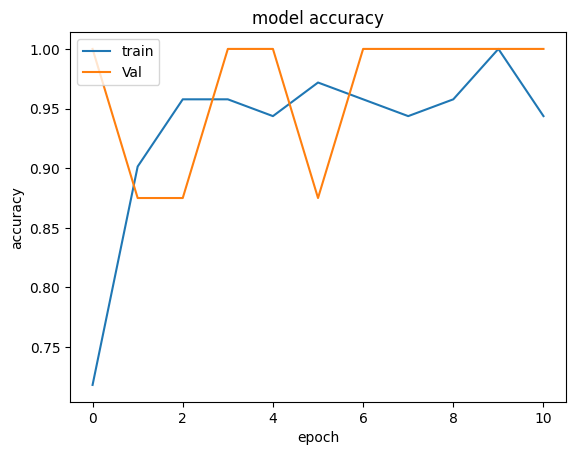

In [185]:
plt.plot(history5.history['binary_accuracy'])
plt.plot(history5.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

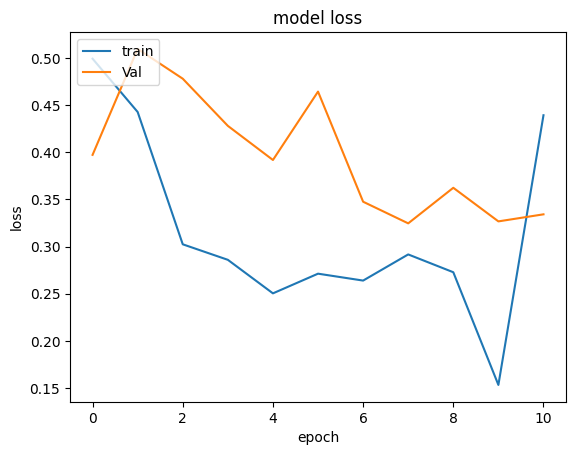

In [186]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

Notamos que no aumentó nada el test accuracy al agregar 100 neuronas por cada capa, por lo que debemos cambiar nuevamente la arquitectura.

**Referencias**

Berti, A., Pucha, R., Juneau, S., Kremin, A., Forero-Romero, J., González, A., & DESI Data Team. (Mayo 2023). *Statistics of EDR targets with multiple spectra*. https://github.com/desihub/tutorials/blob/edr_colab/getting_started/EDR_AnalyzeZcat_colab.ipynb

(Julio 2023). *Stars*. NASA Science. https://science.nasa.gov/astrophysics/focus-areas/how-do-stars-form-and-evolve/

(ND). *Quasar*. ESA/HUBBLE. https://esahubble.org/wordbank/quasar/